In [12]:
import numpy as np
from keras import layers
from keras import metrics
from keras.layers import Input, Add, Dense, Activation, Dropout, BatchNormalization
from keras.models import Model, load_model, Sequential
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import keras.backend as K
from pandas import DataFrame

%matplotlib inline


In [2]:
# load dataset
#parameters0 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\01MachineLearningNoMinUncert\\parameters.csv", delimiter=",")
# The first dataset contained 16 parameters, we will remove the 10 additional compared to the other days
#parameters0 = parameters0[:,[0,1,5,6,10,11]]
#dataset0 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\01MachineLearningNoMinUncert\\atom87_2\\combined.csv", delimiter=",")
parameters1 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\01MachineTheta5\\parameters.csv", delimiter=",")
dataset1 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\01MachineTheta5\\atom87\\combined.csv", delimiter=",")
# Remove parameters from day 1 that had a difference image size
parameters1 = parameters1[38:,:]
parameters2 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\02neldermead\\parameters.csv", delimiter=",")
dataset2 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\02neldermead\\atom87\\combined.csv", delimiter=",")
#parameters3 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\03MachineTheta10\\parameters.csv", delimiter=",")
#dataset3 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\03MachineTheta10\\atom87\\combined.csv", delimiter=",")
#parameters4 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\04MachineTheta10Param7\\parameters.csv", delimiter=",")
# Days 4 and 5 used an additional 7th parameter, which we'll remove
#parameters4 = parameters4[:, [0,1,2,3,4,5]]
#dataset4 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\04MachineTheta10Param7\\atom87\\combined.csv", delimiter=",")
#parameters5 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\01MachineTheta5\\parameters.csv", delimiter=",")
#parameters5 = parameters5[:, [0,1,2,3,4,5]]
#dataset5 = np.loadtxt("C:\\Users\\Me\\Downloads\\BEC_data\\01MachineTheta5\\atom87\\combined.csv", delimiter=",")
parameters = np.concatenate((parameters1, parameters2), axis=0)
dataset = np.concatenate((dataset1, dataset2), axis=0)
# split into input (X) and output (Y) variables
X_train, X_test, Y_train, Y_test = train_test_split(parameters, dataset, test_size=0.1)

In [3]:
def neg_mean_absolute_error(y_true, y_pred):
    return K.mean(y_pred)

In [21]:
# create model
def create_model(input_size, layer_sizes, layer_activation='relu', loss_function='mean_squared_error', final_activation='sigmoid', learning_rate=0.0001, residual=0, dropout=0, drop_rate=0.1):
    # This function creates and returns a model of a network based on the input parameters provided
    # input_size is the number of input parameters to the network
    # layer_sizes is an array with each number specifying the number of neurons in each successive layer
    # layer_activation is the activation function to use on each hidden layer of the network. Default is relu.
    # loss_function is the loss function to use to optimise the network
    # final_activation is the activation function to use on the output layer of the network
    # learning_rate is the learning rate for the optimiser
    # residual is not yet implemented
    # dropout specifies whether to use dropout (0=no, 1=yes)
    # drop_rate is the rate of dropout to apply if dropout=1
    
    num_layers = len(layer_sizes)
    
    # create the input tensor and add batch normalisation
    inputs = Input(shape=(input_size,))
    x = BatchNormalization(input_shape=(input_size,))(inputs)
       
    # The first layer
    x = Dense(layer_sizes[0], activation=layer_activation, kernel_initializer='TruncatedNormal',
                bias_initializer='zeros')(x)
    
    #Then loop over the intermediate layers
    for layer in range(1,(num_layers-1)):
        if residual:
            #Not yet implimented
            #x = res_block(x, layer_sizes[layer])
            None
        else:
            x = Dense(layer_sizes[layer], activation=layer_activation, kernel_initializer='TruncatedNormal',
                bias_initializer='zeros')(x)
            if dropout:
                x = Dropout(drop_rate)(x)
            
    #Then add the final output layer
    x = Dense(layer_sizes[num_layers-1], activation=final_activation, kernel_initializer='TruncatedNormal', bias_initializer='zeros')(x)
    
    #Convert into a model
    model = Model(inputs=inputs, outputs=x)
    
    #And compile the model
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])        
    
    return model

In [22]:
# Define the wrapper
model = KerasClassifier(build_fn=create_model, input_size=6, epochs=5)

In [30]:
param_grid = dict(layer_sizes=[[6, 16, 32, 64, 128, 1024, 2048, 4096, 31020],[1024, 31020]], loss_function=['mean_absolute_error'], final_activation=['linear'])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, return_train_score=True)
grid_result = grid.fit(parameters, dataset)

# Create the model, and then fit it
#model = create_model(input_size=6, layer_sizes=[6, 16, 32, 64, 128, 256, 512, 1000, 31020], dropout=0, drop_rate=0.1)
#model.fit(X_train, Y_train, epochs=30)

Epoch 1/5
233/233 [==============================] - 23s - loss: 0.1978 - acc: 0.0000e+00    
Epoch 2/5
233/233 [==============================] - 19s - loss: 0.1975 - acc: 0.0000e+00    
Epoch 3/5
233/233 [==============================] - 18s - loss: 0.1970 - acc: 0.0000e+00    
Epoch 4/5
233/233 [==============================] - 19s - loss: 0.1951 - acc: 0.0000e+00    
Epoch 5/5
233/233 [==============================] - 2s     
Epoch 1/5
233/233 [==============================] - 23s - loss: 0.1311 - acc: 0.0000e+00    
Epoch 2/5
233/233 [==============================] - 18s - loss: 0.1310 - acc: 0.0000e+00    
Epoch 3/5
233/233 [==============================] - 18s - loss: 0.1309 - acc: 0.0000e+00    
Epoch 4/5
233/233 [==============================] - 19s - loss: 0.1308 - acc: 0.0000e+00    
Epoch 5/5
233/233 [==============================] - 2s     
Epoch 1/5
234/234 [==============================] - 24s - loss: 0.2050 - acc: 0.0000e+00    
Epoch 2/5
234/234 [=============

In [31]:
print("Tuned Parameters: {}".format(grid_result.best_params_))
print("Best score is {}".format(grid_result.best_score_))
DataFrame(data=grid_result.cv_results_)

Tuned Parameters: {'final_activation': 'linear', 'layer_sizes': [6, 16, 32, 64, 128, 1024, 2048, 4096, 31020], 'loss_function': 'mean_absolute_error'}
Best score is 0.0


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_final_activation,param_layer_sizes,param_loss_function,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,101.810774,1.679880,0.0,0.0,linear,"[6, 16, 32, 64, 128, 1024, 2048, 4096, 31020]",mean_absolute_error,"{'final_activation': 'linear', 'layer_sizes': ...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.425974,0.043835,0.0,0.0
1,27.896323,0.944671,0.0,0.0,linear,"[1024, 31020]",mean_absolute_error,"{'final_activation': 'linear', 'layer_sizes': ...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.933542,0.029776,0.0,0.0


In [10]:
# calculate predictions
predictions = model.predict(X_test)
# round predictions (if needed)
rounded = [round(x[0]) for x in predictions]
# Display a predictd output next to the actual output
im_pred = predictions[1,:].reshape(188,165)
im_act = Y_test[1,:].reshape(188,165)
plt.gray()
f, axarr = plt.subplots(2, sharex=False)
axarr[0].imshow(im_pred)
axarr[0].set_title('Prediction')
axarr[1].imshow(im_act)
axarr[1].set_title('Actual')

AttributeError: 'KerasClassifier' object has no attribute 'model'

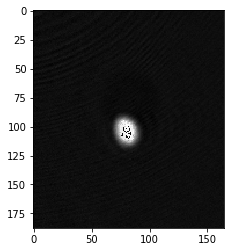

In [12]:
temp = dataset[100,:].reshape(188,165)
imshow(temp)